In [1]:
import pint
si = pint.UnitRegistry()

In [2]:
from matplotlib import pyplot
si.setup_matplotlib()

In [3]:
%run mpdata.ipynb

In [298]:
%run coord.ipynb

In [299]:
def plot_init():
    pyplot.grid()
    
def plot_step(r, psi, t):
    pyplot.step(mpdata.r, mpdata.psi, linestyle='--', where='mid', label=str(t))

In [306]:
nr = 32 # TODO: velocity depends on nr !!!
nt = 3
dt = .5 * si.second
r_min = 10 * si.micrometre
r_max = 100 * si.micrometre
r_mid = r_min + .4*(r_max - r_min) 
psi0 = lambda r: 1 / ((r-r_mid)**2 + 1 * r_mid.units**2)

drdt = lambda r: .5 * si.micrometre / si.second

AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: 2.835494993779452
 DESIRED: 2.8354046465673513

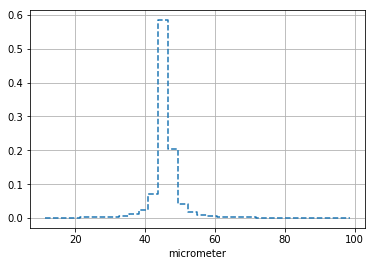

In [307]:
mpdata = MPDATA(nr, r_min, r_max, dt, psi0, x_id(si))

plot_init()
plot_step(mpdata.r, mpdata.psi, 0)

for t in range(nt): 
    mpdata.step(drdt)
plot_step(mpdata.r, mpdata.psi, t+1)

AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: 2.8621010480189857
 DESIRED: 2.8933670790624992

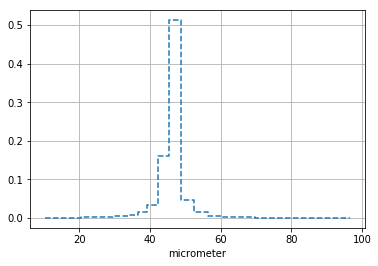

In [308]:
mpdata = MPDATA(nr, r_min, r_max, dt, psi0, x_ln(si))

plot_init()
plot_step(mpdata.r, mpdata.psi, 0)

for t in range(nt): 
    mpdata.step(drdt)
plot_step(mpdata.r, mpdata.psi, t+1)